# Computing Errors of Pose Prediction from PvNet

This notebook is to walk through the process of computing errors of pose prediction result from PvNet, including translation error and angular(rotation) error.

Let's say we have a set of predicted poses represented by transformation matrices in world frame: 
$$\{{T_{pre}^{world}}\}_i = \begin{bmatrix} R_{pre}^{world}& t_{pre}^{world} \\ 0&1 \end{bmatrix}_i $$
where $R_{pre}^{world}$ is the 3x3 rotation matrix representing the predicted rotation, and $t_{pre}^{world}$ is the 3x1 translation vector representing the predicted translation of the $i$-th pose.

Similarly, we have a set of corresponding ground truth poses represented by transformation matrices in world frame:
$$\{{T_{gt}^{world}}\}_i = \begin{bmatrix} R_{gt}^{world}& t_{gt}^{world} \\ 0&1 \end{bmatrix}_i $$

<!-- To simplify our discussion, let's assume that the transformation matrices $T_{gt}$ and $T_{pre}$ without superscripts are given in the world frame. -->

## 1. Translation Error

### 1.1 Method
The translation error can be calculated as the Euclidean distance between $t_{pre}=(x_1, y_1, z_1)$ and $t_{gt}=(x_2, y_2, z_2)$. 

Mathematically, the translation error for each dimension is given by:
$$
\text{x\_error}_{i} = | x_1 - x_2 |
$$
$$
\text{y\_error}_{i} = | y_1 - y_2 |
$$
$$
\text{z\_error}_{i} = | z_1 - z_2 |
$$

#### Implementation

In [1]:
import numpy as np

def translation_error(T_pre, T_gt):
    t_pre = T_pre[:3, 3]
    t_gt = T_gt[:3, 3]
    translation_error = np.abs(t_pre - t_gt)
    # translation_error = t_pre - t_gt
    return translation_error

#### Example

In [2]:
T_gt = np.array([
    [-0.9992905, -0.02776036, 0.02545223, -0.0097374 ],
    [-0.01929233, 0.95770321, 0.2871104,   0.01518335],
    [-0.03234596, 0.2864157, -0.95755938,  1.51049271],
    [0., 0., 0., 1.]
])

T_pre = np.array([
    [-0.9995757, -0.02325838,  0.0175349, -0.00948184],
    [-0.01803212, 0.96688755,  0.25456493, 0.014642  ],
    [-0.02287504, 0.25414072, -0.9668967,  1.46206129],
    [0., 0., 0., 1.]
])

In [3]:
t_error = translation_error(T_pre, T_gt)
print(f"x error = {t_error[0]*1000:.2f} mm")
print(f"y error = {t_error[1]*1000:.2f} mm")
print(f"z error = {t_error[2]*1000:.2f} mm")

x error = 0.26 mm
y error = 0.54 mm
z error = 48.43 mm


## 2. Angular Error

### 2.1 Method1 - Using rotation matrices
The angular error is the difference between the predicted rotation $R_{pre}^{world}$ and $R_{gt}^{world}$. Mathematically,

$$R_{pre}^{gt} = R_{world}^{gt} R_{pre}^{world} = (R_{gt}^{world})^T R_{pre}^{world}$$
$$\theta = \cos^{-1} \left(\dfrac{\text{trace}\left( R_{pre}^{gt} \right) - 1}{2}\right) $$

Reference: 

[1. Axis–angle representation - WIKIPEDIA](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Exponential_map_from_so.283.29_to_SO.283.29)

[2. Distance between rotations - Blog](http://www.boris-belousov.net/2016/12/01/quat-dist/#using-quaternions)

Implementation

In [4]:
def angular_R_error(T_pre, T_gt):
    R_pre_in_world = T_pre[:3, :3]
    R_gt_in_world = T_gt[:3, :3]
    R_pre_in_gt = R_gt_in_world.T @ R_pre_in_world
    trace = np.trace(R_pre_in_gt)
    angular_distance = np.rad2deg(np.arccos((trace - 1.) / 2.))
    return angular_distance

In [5]:
angular_R_err = angular_R_error(T_pre, T_gt)
print(f"Angular Error computed by R matrices = {angular_R_err:.2f} deg")

Angular Error computed by R matrices = 2.00 deg


### 2.2 Method2 - Using Quaternions
Firstly, convert rotation matrices to quaternion representation. Let $q_{pre}$ and $q_{gt}$ be unit quaternions representing two rotations in the same basis, and they are converted from $R_{pre}^{world}$ and $R_{gt}^{world}$ respectively.

The quaternion that represents the difference rotation is defined as $$r= q_{gt}^* q_{pre} = [r_w, \vec{r_x}, \vec{r_y}, \vec{r_z}]$$

,where the scalar component is computed as:
 $$r_w = \cos(\frac{\theta}{2}) = q_{gt1}q_{pre1}+q_{gt2}q_{pre2} + q_{gt3}q_{pre3} + q_{gt4}q_{pre4}$$

using the $arcos$ function $$\theta = 2\arccos(q_{gt1}q_{pre1}+q_{gt2}q_{pre2} + q_{gt3}q_{pre3} + q_{gt4}q_{pre4})= 2\arccos(|<q_{gt},q_{pre}>|)$$

Reference: 

[1. Axis–angle representation - WIKIPEDIA](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Exponential_map_from_so.283.29_to_SO.283.29)

[2. Distance between rotations - Blog](http://www.boris-belousov.net/2016/12/01/quat-dist/#using-quaternions)

Implementation

In [6]:
import transforms3d.quaternions as tf_quaternions
def angular_quaternion_error(T_pre, T_gt):
    R_pre = T_pre[:3, :3]
    R_gt = T_gt[:3, :3]

    # Convert rotation matrices to quaternion representations
    q1 = tf_quaternions.mat2quat(R_pre)
    q2 = tf_quaternions.mat2quat(R_gt)
    
    # Compute the dot product between the quaternions
    r_w = np.dot(q1, q2)

    angular_diff = 2 * np.arccos(abs(r_w))
    # Convert angular difference to degrees
    angular_diff_deg = np.rad2deg(angular_diff)
    return angular_diff_deg

In [7]:
angular_quaternion_err = angular_quaternion_error(T_pre, T_gt)
print(f"Angular Error computed by Quaternion = {angular_quaternion_err:.2f} deg")
print(f"Angular Error computed by R matrices = {angular_R_err:.2f} deg")

Angular Error computed by Quaternion = 2.00 deg
Angular Error computed by R matrices = 2.00 deg


## 3. Compute mean and std

In [8]:
######################################################################################################################
# Download necessary files from : https://drive.google.com/drive/folders/1tr3cR7HIf3QJjgBYUlS537eo2RqXlw0V?usp=sharing
######################################################################################################################
import os
import numpy as np

###################################################
# Please Modify the path and part name accordingly 
###################################################
path = "/home/yangfei/clean-pvnet/data/evaluation/"
# part = "insert_mold"
# part = "mainshell"
part = "topshell"

# Load T_gts (ground truth transformations) from a .npy file and print information
path_T_gt = os.path.join(path, f"T_gt_{part}.npy")
T_gts = np.load(path_T_gt)
print("Number of ground truth transformations loaded:", len(T_gts))
print("Example of the first ground truth transformation:\n", T_gts[0], "\n")

# Load T_pres (predicted transformations) from a .npy file and print information
path_T_pre = os.path.join(path, f"T_pre_{part}.npy")
T_pres = np.load(path_T_pre)
print("Number of predicted transformations loaded:", len(T_pres), "\n")

# Calculate and print translation errors between ground truth and predicted transformations
trans_err = []
for i in range(len(T_gts)):
    t_err = translation_error(T_gts[i], T_pres[i])
    t_err = t_err * 1000  # Convert from meters to millimeters
    if(np.abs(t_err[2])>200):
        continue
    trans_err.append(t_err)
trans_err = np.array(trans_err)
print("Number of translation errors calculated:", len(trans_err))
print(f"Example of the first translation error (unit: mm): {trans_err[0]}\n")

# Calculate and print angular rotation errors between ground truth and predicted transformations
R_err = []
for i in range(len(T_gts)):
    r_err = angular_R_error(T_gts[i], T_pres[i])
    if(r_err>30):
        continue
    R_err.append(r_err)
R_err = np.array(R_err)
print("Number of angular rotation errors calculated:", len(R_err))
print("Example of the first angular rotation error:", R_err[0], "\n")

# Calculate and print angular quaternion errors between ground truth and predicted transformations
Q_err = []
for i in range(len(T_gts)):
    q_err = angular_quaternion_error(T_gts[i], T_pres[i])
    if(q_err>30):
        continue
    Q_err.append(q_err)
Q_err = np.array(Q_err)
print("Number of angular quaternion errors calculated:", len(Q_err))
print("Example of the first angular quaternion error:", Q_err[0], "\n")


Number of ground truth transformations loaded: 2000
Example of the first ground truth transformation:
 [[ 0.83033958 -0.55624098 -0.03364829  0.02530932]
 [ 0.55724341  0.82836933  0.05730641  0.02707996]
 [-0.00400297 -0.06633406  0.99778946  1.84286645]] 

Number of predicted transformations loaded: 2000 

Number of translation errors calculated: 1999
Example of the first translation error (unit: mm): [ 1.11781324  1.3266628  86.50063188]

Number of angular rotation errors calculated: 1997
Example of the first angular rotation error: 3.1106305439770563 

Number of angular quaternion errors calculated: 1997
Example of the first angular quaternion error: 3.11064512857845 



In [9]:
trans_err_mean = np.mean(trans_err, axis=0)
trans_err_std = np.std(trans_err, axis=0)

angular_rotation = np.mean(R_err)
angular_rotation_std = np.std(R_err)

angular_quat = np.mean(Q_err)
angular_quat_std = np.std(Q_err)

print('Translation Error (X-axis): {:.2f} mm, std {:.2f}'.format(trans_err_mean[0], trans_err_std[0]))
print('Translation Error (Y-axis): {:.2f} mm, std {:.2f}'.format(trans_err_mean[1], trans_err_std[1]))
print('Translation Error (Z-axis): {:.2f} mm, std {:.2f}'.format(trans_err_mean[2], trans_err_std[2]))

print('Angular Error (rotation)  : {:.2f} deg, std {:.2f}'.format(angular_rotation, angular_rotation_std))
print('Angular Error (quaternion): {:.2f} deg, std {:.2f}'.format(angular_quat, angular_quat_std))

Translation Error (X-axis): 0.74 mm, std 0.54
Translation Error (Y-axis): 0.71 mm, std 0.54
Translation Error (Z-axis): 75.90 mm, std 23.13
Angular Error (rotation)  : 3.31 deg, std 2.09
Angular Error (quaternion): 3.31 deg, std 2.09


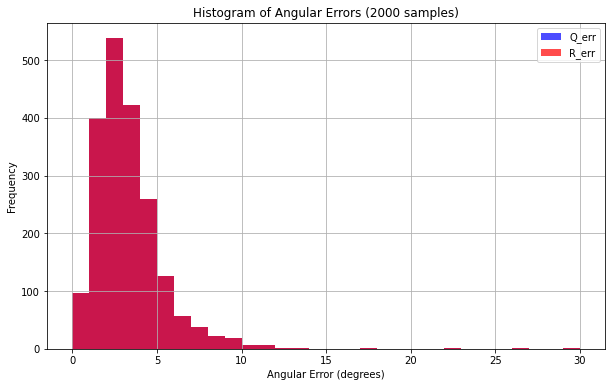

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create histograms
plt.figure(figsize=(10, 6))

# Histogram for Q_err
plt.hist(Q_err, bins=30, range=(0, 30), alpha=0.7, color='blue', label='Q_err')

# Histogram for R_err
plt.hist(R_err, bins=30, range=(0, 30), alpha=0.7, color='red', label='R_err')

plt.xlabel('Angular Error (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Angular Errors (2000 samples)')
plt.legend()
plt.grid(True)

plt.show()

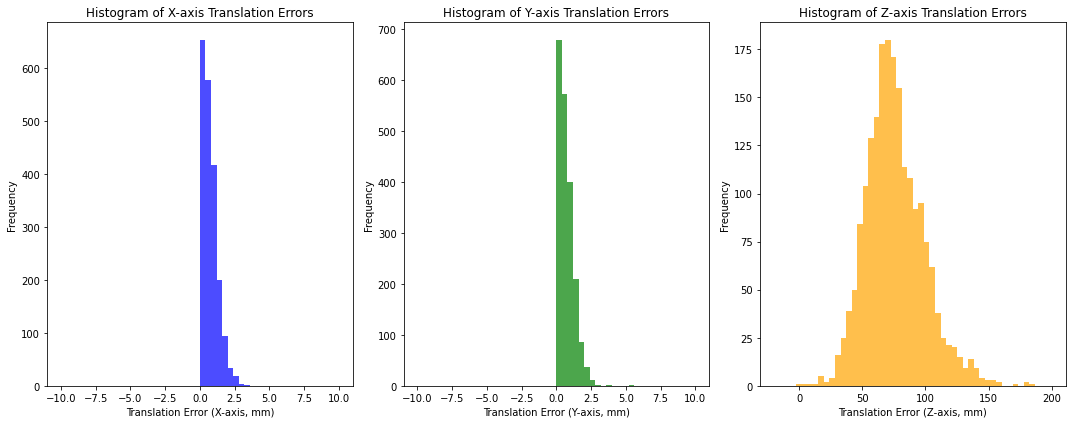

In [11]:
# Create histograms
plt.figure(figsize=(15, 6))

# Histogram for X-axis translation error
plt.subplot(131)
plt.hist(trans_err[:, 0], bins=50, range=(-10, 10), alpha=0.7, color='blue')
plt.xlabel('Translation Error (X-axis, mm)')
plt.ylabel('Frequency')
plt.title('Histogram of X-axis Translation Errors')

# Histogram for Y-axis translation error
plt.subplot(132)
plt.hist(trans_err[:, 1], bins=50, range=(-10, 10), alpha=0.7, color='green')
plt.xlabel('Translation Error (Y-axis, mm)')
plt.ylabel('Frequency')
plt.title('Histogram of Y-axis Translation Errors')

# Histogram for Z-axis translation error
plt.subplot(133)
plt.hist(trans_err[:, 2], bins=50, range=(-20, 200), alpha=0.7, color='orange')
plt.xlabel('Translation Error (Z-axis, mm)')
plt.ylabel('Frequency')
plt.title('Histogram of Z-axis Translation Errors')

plt.tight_layout()  # To improve spacing between subplots
plt.show()

Maximum X-axis Translation Error: 3.47 mm
Maximum Y-axis Translation Error: 5.35 mm
Maximum Z-axis Translation Error: 185.80 mm


Number of occurrences with X-axis error > 10 mm: 0
Number of occurrences with Y-axis error > 10 mm: 0
Number of occurrences with Z-axis error > 200 mm: 0

Maximum Rotation Error Index: 1408
Maximum Rotation Error: 29.83 deg


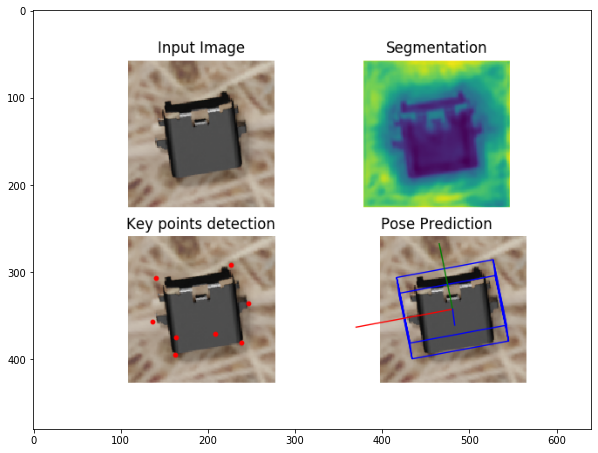

In [12]:
# Find the maximum values for X, Y, and Z translation errors
max_x = np.max(trans_err[:, 0])
max_y = np.max(trans_err[:, 1])
max_z = np.max(trans_err[:, 2])

# Print out the results
print('Maximum X-axis Translation Error: {:.2f} mm'.format(max_x))
print('Maximum Y-axis Translation Error: {:.2f} mm'.format(max_y))
print('Maximum Z-axis Translation Error: {:.2f} mm\n'.format(max_z))


# Find number of occurrences that error is larger than 10 mm for each axis
count_x_gt_10 = np.sum(trans_err[:, 0] > 10)
count_y_gt_10 = np.sum(trans_err[:, 1] > 10)
count_z_gt_10 = np.sum(trans_err[:, 2] > 200)

print()
print('Number of occurrences with X-axis error > 10 mm: {}'.format(count_x_gt_10))
print('Number of occurrences with Y-axis error > 10 mm: {}'.format(count_y_gt_10))
print('Number of occurrences with Z-axis error > 200 mm: {}\n'.format(count_z_gt_10))

print('Maximum Rotation Error Index: {}'.format(np.argmax(R_err)))
print('Maximum Rotation Error: {:.2f} deg'.format(np.max(R_err)))
import matplotlib.image as mpimg
path_to_example = f"/home/yangfei/clean-pvnet/data/evaluation/{part}.png"
img = mpimg.imread(path_to_example)
plt.figure(figsize=(10, 8))
plt.imshow(img)

#### Comparison between R_err and Q_err

In [13]:
# Calculate the absolute differences between Q_err and R_err for each corresponding element
angular_diff = np.abs(Q_err - R_err)

# Find the index with the maximum difference
max_diff_index = np.argmax(angular_diff)

# Print the index and the corresponding difference
print(f"Index with the largest difference: {max_diff_index}")
print(f"Largest Angular Error Difference: {angular_diff[max_diff_index]:.2f} deg\n")

# The output domain of 'np.arccos' is [0, pi]. 
# Ref: https://numpy.org/doc/stable/reference/generated/numpy.arccos.html
print(f"R_err[{max_diff_index}] = {R_err[max_diff_index]}")
print(f"Q_err[{max_diff_index}] = {Q_err[max_diff_index]}")

Index with the largest difference: 64
Largest Angular Error Difference: 0.00 deg

R_err[64] = 0.3353180036404704
Q_err[64] = 0.33264565220437986
